# How to use the RNN Disaggregator with NILMTK
This is an example on how to train and use the Recurrent Network (RNN) disaggregator on the REDD dataset using NILMTK.

This network was described in the Neural NILM paper.

First of all, we need to train the RNNDisaggregator using the train data. For this example, both train and test data are consumption data of the microwave of the first REDD building.

In [1]:
import nilmtk

In [2]:
import warnings; warnings.filterwarnings('ignore')

from nilmtk import DataSet
train = DataSet('redd.h5')
train.set_window(end="30-4-2011") #Use data only until 4/30/2011
train_elec = train.buildings[1].elec

Next, we need to define the disaggregator model. For this example, the input window will have size of 200 samples.



In [14]:
! pip3 install -r requirements.txt

  Using cached attrs-19.3.0-py2.py3-none-any.whl (39 kB)
  Using cached backcall-0.1.0.tar.gz (9.7 kB)
  Using cached bleach-3.1.0-py2.py3-none-any.whl (157 kB)
  Using cached Bottleneck-1.3.1.tar.gz (88 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached certifi-2019.11.28-py2.py3-none-any.whl (156 kB)
  Using cached coverage-4.5.4-cp36-cp36m-win_amd64.whl (183 kB)
  Using cached Cython-0.29.14-cp36-cp36m-win_amd64.whl (1.7 MB)
  Using cached decorator-4.4.1-py2.py3-none-any.whl (9.2 kB)
  Using cached hmmlearn-0.2.2.tar.gz (146 kB)
  Using cached importlib_metadata-1.3.0-py2.py3-none-any.whl (29 kB)
  Using cached ipykernel-5.1.3-py3-none-any.whl (116 kB)
  Using cached ipython-7.10.1-py3-none-any.whl (778 kB)

ERROR: Could not find a version that satisfies the requirement nilmtk===0.4.0.dev1-git. (from -r requirements.txt (line 41)) (from versions: none)
ERROR: No matching distribution found for nilmtk===0.4.0.dev1-git. (from -r requirements.txt (line 41))


In [15]:
from rnndisaggregator import RNNDisaggregator
rnn = RNNDisaggregator()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [16]:
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['microwave'] # The microwave meter that is used as a training target

rnn.train(train_mains, train_meter, epochs=5, sample_period=1)
rnn.export_model("model-redd5.h5")

Epoch 1/5
7837/7837 [==============================] - 201s 26ms/step - loss: 0.0011
Epoch 2/5
7837/7837 [==============================] - 210s 27ms/step - loss: 7.2304e-04
Epoch 3/5
7837/7837 [==============================] - 213s 27ms/step - loss: 6.6192e-04
Epoch 4/5
7837/7837 [==============================] - 207s 26ms/step - loss: 6.5089e-04
Epoch 5/5
7837/7837 [==============================] - 210s 27ms/step - loss: 6.4895e-04



Now that the model is trained, we can use it to disaggregate energy data. Let's test it on the rest of the data from building 1.

First we use the model to predict the microwave consumption. The results are saved automatically in a .h5 datastore.

In [17]:
test = DataSet('redd.h5')
test.set_window(start="30-4-2011")
test_elec = test.buildings[1].elec
test_mains = test_elec.mains().all_meters()[0]

disag_filename = 'disag-out.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
rnn.disaggregate(test_mains, output, train_meter, sample_period=1)


New sensible chunk: 121482
New sensible chunk: 112661
New sensible chunk: 87770
New sensible chunk: 54084
New sensible chunk: 2660
New sensible chunk: 33513
New sensible chunk: 138535
New sensible chunk: 32514
New sensible chunk: 27255
New sensible chunk: 34833
New sensible chunk: 100831


Let's plot the results and compare them to the ground truth signal.

Note: Calling plot this way, downsamples the signal to reduce computing time. To plot the entire signal call

predicted.power_series_all_data().plot()
ground_truth.power_series_all_data().plot()

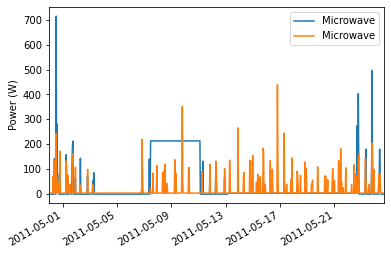

In [18]:
result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['microwave']
ground_truth = test_elec['microwave']

import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

In [19]:

import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

============ Recall: 0.045375939578173624
============ Precision: 0.8052601230138391
============ Accuracy: 0.2830801149400639
============ F1 Score: 0.0859108525807091
============ Relative error in total energy: 0.8162269750051222
============ Mean absolute error(in Watts): 23.57142870284622
